In [2]:
%pip install datasets

In [3]:
!pip install --upgrade --force-reinstall numpy==1.26.4 scipy==1.13.1 datasets gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.4/72.4 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 64.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.3/484.3 kB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### 1. Dataset Overview

In [1]:
# Install the `datasets` library if it's not already installed

from datasets import load_dataset

# Login using e.g. `huggingface-cli login` to access this dataset
dataset = load_dataset("surrey-nlp/PLOD-CW-25")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/268 [00:00<?, ?B/s]

PLOD-CW-25-Train.parquet:   0%|          | 0.00/343k [00:00<?, ?B/s]

PLOD-CW-25-Test.parquet:   0%|          | 0.00/55.5k [00:00<?, ?B/s]

PLOD-CW-25-Val.parquet:   0%|          | 0.00/35.9k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/250 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/150 [00:00<?, ? examples/s]

In [ ]:
dataset

##### Checking missing values

In [ ]:
def check_missing(dataset_split):
    missing_counts = {}
    for feature in dataset_split.features:
        count = sum(1 for example in dataset_split if example[feature] is None)
        missing_counts[feature] = count
    return missing_counts

for split in dataset:
    print(f"\nMissing values in {split}:")
    print(check_missing(dataset[split]))


In [ ]:
#Get the total number of sentences in each split
print("\nNumber of Sentences in Each Split:")
for split in dataset.keys():
    print(f"{split.capitalize()} Split: {len(dataset[split])} sentences")

##### Token and TAG Distributions

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

# Flatten all tokens from train split and convert to lowercase
all_tokens = [token.lower() for example in dataset['train'] for token in example['tokens']]
token_freq = Counter(all_tokens)
top_tokens = token_freq.most_common(20)

# Plot top 20 most frequent tokens
words, freqs = zip(*top_tokens)
plt.figure(figsize=(10,4))
plt.bar(words, freqs)
plt.xticks(rotation=45)
plt.title("Top 20 Frequent Tokens")
plt.show()

Key insights:
1. Punctuation (',', '(', ')', '.') and stopwords ("the", "of", "and") are the most frequent tokens.

2. Biomedical terms or abbreviations are not visible in the top 20.

3. Suggests that non-entity tokens dominate the dataset, highlighting the importance of focusing on labeled tokens for biomedical analysis.

In [ ]:
from collections import Counter

all_pos = [pos for sentence in dataset['train']['pos_tags'] for pos in sentence]
pos_counts = Counter(all_pos)

plt.figure(figsize=(8, 4))
plt.bar(pos_counts.keys(), pos_counts.values())
plt.title("POS Tag Distribution (Training Set)")
plt.xlabel("POS Tag")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

Key insights:

1. NOUN and PUNCT are the most frequent POS tags, followed by proper nouns (PROPN) and adjectives (ADJ).

2. Indicates that biomedical terms likely appear as nouns or proper nouns, with heavy punctuation usage (typical of scientific text).

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

# Flatten all NER tags from the training set
all_ner_labels = [label for ex in dataset['train'] for label in ex['ner_tags']]

# Count the frequency of each NER tag
label_counts = Counter(all_ner_labels)

# Plot the distribution
plt.bar(label_counts.keys(), label_counts.values())
plt.title("NER Label Distribution in Training Set")
plt.xlabel("NER Label")
plt.ylabel("Count")
plt.show()

Key insights

1. Majority of tokens are labeled as O (non-entity).

2. Among labeled tokens, I-LF (inside long-form) is the most common, followed by B-AC (abbreviation) and B-LF (begin long-form).

3. Shows class imbalance, with many more non-entity tokens than labeled entities — important for model training and evaluation.

### 2. Word Frequency (excluding 'O')

In [ ]:
# TODO: ADD THE GRAPH FOR WORD FREQUENCY IGNORING THE 'O' TAGS -> amir
from collections import Counter
import matplotlib.pyplot as plt

tokens = []

for row in dataset['train']:
  for token, tag in zip(row['tokens'], row['ner_tags']):
    if tag != 'O' and len(token) > 1:
      tokens.append(token)

token_freq = Counter(tokens)
top_tokens = token_freq.most_common(20)
print(top_tokens)

words, freqs = zip(*top_tokens)
plt.figure(figsize=(15,5))
plt.bar(words, freqs)


Key insights:

1.Generic words like “of”, “and”, and “the” still appear frequently even in labeled tokens, suggesting that some long-forms may contain common English words.

2. Domain-specific terms such as “protein”, “cell”, “disease”, “ratio”, “receptor”, and “RNA” are among the top frequent labeled tokens, reflecting the biomedical nature of the dataset.

3. Some abbreviations like “CI”, “WT”, and “RNA” appear, indicating that abbreviation labels (B-AC) are being captured in the top frequencies.

4. The presence of common functional words in the labeled tokens highlights that biomedical entities often contain stopwords (e.g., "confidence interval", "protein of interest").

### 3. Top Abbreviated Words

In [ ]:
# TODO: SHOW TOP ABBRIVIATED WORDS -> shivasmi
from collections import Counter
import matplotlib.pyplot as plt
import re

abbreviation_counts = Counter()

# Working only on the train split
for example in dataset["train"]:
    tokens = example['tokens']
    tags = example['ner_tags']

    for token, tag in zip(tokens, tags):
        # Allow letters (A-Z, a-z), numbers (0-9), and hyphens (-), length > 1
        if tag == "B-AC" and re.match(r"^[A-Za-z0-9\-]+$", token) and len(token) > 1:
            abbreviation_counts[token] += 1

# Show Top 10 Abbreviated Words after filtering
print("\nTop Abbreviated Words:")
for abbr, count in abbreviation_counts.most_common(10):
    print(f"{abbr:<10} → {count}")

In [ ]:
# Get the top 10 abbreviations and their counts
top_abbr, top_counts = zip(*abbreviation_counts.most_common(10))

# Plotting with better style
plt.figure(figsize=(10, 6))
bars = plt.bar(top_abbr, top_counts, color='#4c72b0', edgecolor='black', linewidth=1.2)

# Add count labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 5),  # Offset label position
                 textcoords="offset points",
                 ha='center', va='bottom', fontsize=10, fontweight='bold')

# Customizing the plot
plt.title("Top Abbreviated Words in Biomedical Text", fontsize=16, fontweight='bold', color='#333333')
plt.xlabel("Abbreviation", fontsize=12, fontweight='bold')
plt.ylabel("Frequency", fontsize=12, fontweight='bold')
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Remove top and right spines for a cleaner look
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

Key insights:

1. “CI” and “WT” are the most frequent abbreviations, followed by “HR”, “OR”, and “BMI”.

2. Abbreviations reflect a mix of statistical terms (e.g., CI, HR, OR) and biomedical entities/diseases (e.g., GFP, TB, MS).

  Indicates the need for domain-aware abbreviation handling in the model.

### 4. Long-form & Abbreviation Relationship

In [ ]:
# TODO: LONG FORMAT AND SHORT FORMAT RELATION -> ishwari
# examples where acronym (B-AC) appears
for i in range(5):
    tags = dataset['train'][i]['ner_tags']
    if 'B-AC' in tags:
        print("Tokens:", dataset['train'][i]['tokens'])
        print("NER Tags:", tags)
        print("---")

# Initializing counters
with_both = 0
only_acronym = 0
only_longform = 0
neither = 0

# Going through each sentence in the training set
for ex in dataset['train']:
    tags = ex['ner_tags']

    has_acronym = 'B-AC' in tags
    has_longform = 'B-LF' in tags or 'I-LF' in tags

    if has_acronym and has_longform:
        with_both += 1
    elif has_acronym:
        only_acronym += 1
    elif has_longform:
        only_longform += 1
    else:
        neither += 1

print("Sentences with BOTH acronym and long form:", with_both)
print("Sentences with ONLY acronym:", only_acronym)
print("Sentences with ONLY long form:", only_longform)
print("Sentences with NEITHER:", neither)
print('\n')

#Visualizing with Bar Chart
import matplotlib.pyplot as plt

labels = ['Both Short & Long', 'Only Short', 'Only Long', 'Neither']
counts = [with_both, only_acronym, only_longform, neither]

plt.figure(figsize=(8, 4))
plt.bar(labels, counts, color='cornflowerblue')
plt.title("Co-occurrence of Acronyms (Short) and Long Forms")
plt.ylabel("Number of Sentences")
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Key Insights:

1. Most sentences (1986) contain both abbreviations and their corresponding long forms, indicating clear abbreviation–long-form pairings.

2. Very few sentences have only abbreviations (2) or only long forms (12), showing that isolated occurrences are rare.

3. No sentences are unlabeled (neither abbreviation nor long form), confirming the dataset is well-annotated.

4. Highlights that sentence-level context is strong for abbreviation detection, as both forms often co-occur together.

### 5. Sentences with Only Abbreviations or Only Long-forms

In [ ]:
# TODO: Sentences with Only Abbreviations or Only Long-forms -> ritwik

print("\nSentences with only abbreviation (B-AC, no B-LF):\n")
count = 0
for ex in dataset["train"]:
    tags = ex["ner_tags"]
    if "B-AC" in tags and "B-LF" not in tags:
        print(" ".join(ex["tokens"]))
        count += 1
        if count >= 3:
            break

Key Insight:
1. Some short forms like CD5-2, TLR2, PD98059, eRNA, etc. are used without explaining their full forms in the same sentence.

In [ ]:
print("\nSentences with only long-form (B-LF, no B-AC):\n")
count = 0
for ex in dataset["train"]:
    tags = ex["ner_tags"]
    if "B-LF" in tags and "B-AC" not in tags:
        print(" ".join(ex["tokens"]))
        count += 1
        if count >= 12:
            break

Key insights:

1. Some technical terms like “chaperone protein DnaK” or “Plasmodium falciparum strain FCR3” are written fully without abbreviation.

2. This happens when:

  -The term is used only once.
  -The term itself is already short or clear.

### 6. Abbreviation ↔ POS Tag Relationship

In [ ]:
# TODO: RELATION BETWEEN ABBRIVIATION AND POS TAG -> faye

import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

# initialise a dictionary to store abbreviation-POS pairs
abbr_pos_counts = defaultdict(lambda: defaultdict(int))

# iterate through the dataset to find abbreviations and their POS tags
for split in ['train', 'validation', 'test']:
    for example in dataset[split]:
        tokens = example['tokens']
        pos_tags = example['pos_tags']

        for token, pos_tag in zip(tokens, pos_tags):
            # check if the token is likely an abbreviation (heuristic: contains '.' or is uppercase)
            if '.' in token or (token.isupper() and len(token) <= 5):
                abbr_pos_counts[token][pos_tag] += 1

# convert to a dataframe for analysis
abbr_pos_df = pd.DataFrame([
    (abbr, pos, count)
    for abbr in abbr_pos_counts
    for pos, count in abbr_pos_counts[abbr].items()
], columns=['Abbreviation', 'POS_Tag', 'Count'])

# display the top abbreviation POS pairs
print(abbr_pos_df.sort_values('Count', ascending=False).head(20))


In [ ]:
# aggregate counts by POS tag
pos_counts = abbr_pos_df.groupby('POS_Tag')['Count'].sum().reset_index()
pos_counts = pos_counts.sort_values('Count', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=pos_counts, x='POS_Tag', y='Count', palette='viridis')
plt.title('Most Common POS Tags for Abbreviations')
plt.xticks(rotation=45)
plt.show()

Key insights:
1. Most abbreviations are tagged as Proper Nouns (PROPN) and Nouns (NOUN), matching common biomedical entities like genes, proteins, and diseases.

2. High PUNCT count suggests tokenization splits (e.g., hyphens in "IL-2") leading to punctuation being misclassified as abbreviations.

3. Presence of NUM (numbers) reflects abbreviations with numeric components (e.g., S1, 2).

### 7. Tag Transition Matrix (NER Transitions)

In [2]:
# TODO: Tag transition - Shivasmi

import pandas as pd
from collections import Counter

def get_all_transitions(dataset_split):
    transitions = Counter()
    for example in dataset_split:
        labels = example['ner_tags']
        for i in range(len(labels) - 1):
            transitions[(labels[i], labels[i + 1])] += 1
    return transitions

def transitions_to_dataframe(transitions):
    data = []
    for (prev_tag, next_tag), count in transitions.items():
        data.append({
            'Previous Tag': prev_tag,
            'Next Tag': next_tag,
            'Count': count
        })
    df = pd.DataFrame(data)
    return df.sort_values(by='Count', ascending=False).reset_index(drop=True)

# Get transitions
train_transitions = get_all_transitions(dataset['train'])

# Convert to DataFrame (no id2label needed!)
df_transitions = transitions_to_dataframe(train_transitions)
print(df_transitions)


   Previous Tag Next Tag  Count
0             O        O  51509
1          I-LF     I-LF   5946
2          B-AC        O   5754
3             O     B-AC   5311
4             O     B-LF   3718
5          B-LF     I-LF   3579
6          I-LF        O   3502
7          B-AC     B-AC    828
8          B-LF        O    338
9          B-AC     B-LF     42
10         I-LF     B-AC     15
11         I-LF     B-LF      5
12         B-LF     B-AC      1


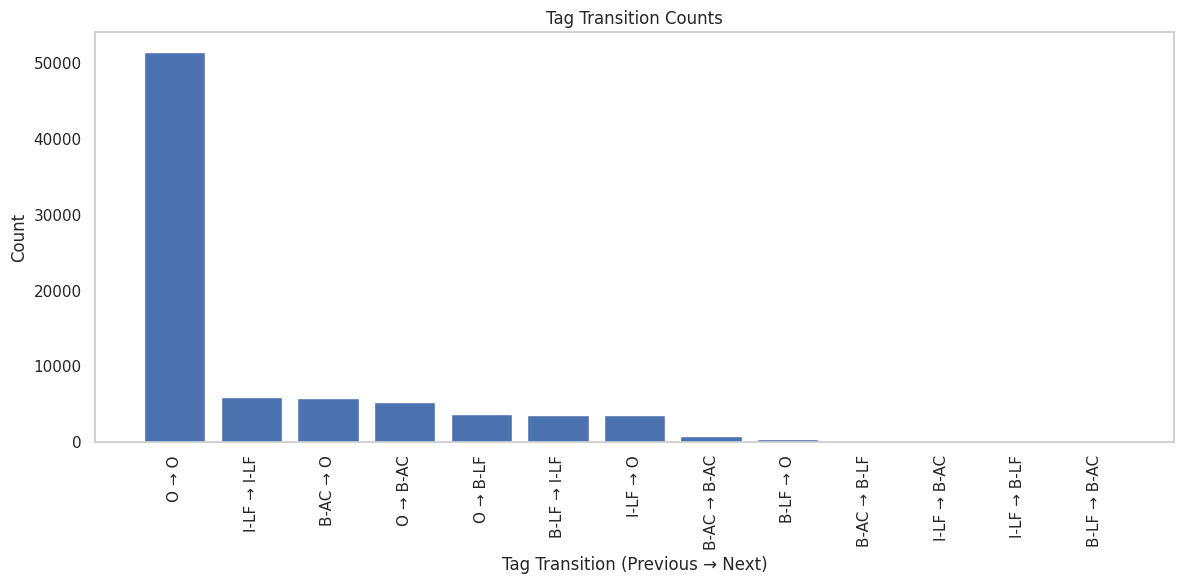

In [6]:
import matplotlib.pyplot as plt

# Prepare labels and counts
labels = df_transitions.apply(lambda x: f"{x['Previous Tag']} → {x['Next Tag']}", axis=1)
counts = df_transitions["Count"]

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(labels, counts)

# Set labels and title
ax.set_ylabel("Count")
ax.set_xlabel("Tag Transition (Previous → Next)")
ax.set_title("Tag Transition Counts")

# Rotate x-axis labels for better visibility
plt.xticks(rotation=90)

# Remove grid
ax.grid(False)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


A. Rare transitions: Transition Count What it may indicate

1. B-AC → B-LF 42; Abbreviation followed immediately by long form
2. I-LF → B-AC 15; Ending long form → new abbreviation without 'O' token between
3. I-LF → B-LF 5; One long form starts right after inside of another long form
4. B-LF → B-AC 1; Very rare: long form followed by abbreviation

B. The majority of transitions are from

1. O → O, reflecting a strong class imbalance toward non-entity tokens.
2. Long forms typically span multiple tokens as shown by frequent B-LF → I-LF and I-LF → I-LF transitions.

Rare transitions such as B-AC → B-LF suggest edge cases where abbreviations are directly followed by long forms, which may challenge sequence-based models.

### 8. Symbol and Token Analysis

In [ ]:
# TODO: SHOW THE SYMBOLS -> amir
from collections import Counter
import matplotlib.pyplot as plt
import re

uncommon_pattern = re.compile(r'[αβγδΔΓΩω]')
tokens = []

for row in dataset['train']:
  for token, tag in zip(row['tokens'], row['ner_tags']):
    if uncommon_pattern.search(token):
      tokens.append(token)

token_freq = Counter(tokens)
top_tokens = token_freq.most_common(20)
print(top_tokens)

words, freqs = zip(*top_tokens)
plt.figure(figsize=(20,5))
plt.bar(words, freqs)



Key insights:
1. Greek letters like α (alpha), β (beta), γ (gamma) are the most frequently occurring symbols in biomedical terms.

2. These symbols are often used in protein names, receptor types, or biological pathways (e.g., TGFβ, Aβ, PDGFRα).

3. The presence of such symbols highlights the importance of correctly handling non-English characters during tokenization and abbreviation detection.

4. Rare symbols like ω (omega), Δ (delta), and their combinations (e.g., Δm157, αSMA) also appear, often representing variants or specific subtypes.

### 9. Abbreviation Ambiguity

In [7]:
# TODO: Abbreviation amibiguity check - ritwik

from collections import defaultdict

abbr_map = defaultdict(set)

for example in dataset['train']:
    tokens = example['tokens']
    tags = example['ner_tags']
    current_abbr = None
    current_lf = []

    for token, tag in zip(tokens, tags):
        if tag == 'B-AC':
            current_abbr = token
        elif tag == 'B-LF':
            current_lf = [token]
        elif tag == 'I-LF' and current_lf:
            current_lf.append(token)
        elif tag == 'O':
            if current_abbr and current_lf:
                abbr_map[current_abbr].add(" ".join(current_lf))
                current_abbr = None
                current_lf = []

# Count ambiguous abbreviations
ambiguous_abbr = {abbr: lfs for abbr, lfs in abbr_map.items() if len(lfs) > 1}
num_ambiguous = len(ambiguous_abbr)

print(f"\n Total Ambiguous Abbreviations: {num_ambiguous}")
print("\nSome Examples of Ambiguous Abbreviations:")

# Show abbreviations with more than one long form
for abbr, lfs in list(ambiguous_abbr.items())[:10]:
    if len(lfs) > 1:
        print(f"{abbr} → {lfs}")


 Total Ambiguous Abbreviations: 437

Some Examples of Ambiguous Abbreviations:
d → {'LV posterior wall thickness at end - diastole', 'LV internal diameter at end - diastole', 'LV anterior wall thickness at end - diastole', 'aquaporin-3'}
HC → {'healthy control', 'Resident Assessment Instrument for Home Care', 'C - terminal receptor - binding domain', 'healthy control participants'}
KD → {'knockdown', 'equilibrium dissociation constant', 'equilibrium dissociation constants', 'knock - down', 'reactive oxygen species', 'kinase - inactive mutant', 'glutathione compound glutathione reduced ethyl ester'}
ND → {'nandrolone decanoate', 'nanodisc'}
AMPK → {'double - stranded RNA', 'AMP - activated protein kinase', 'FOrkhead boX O'}
HbA1c → {'haemoglobin A1c', 'glycated haemoglobin', 'glycated hemoglobin', 'Glycated Hemoglobin', 'high - density lipoprotein', 'hemoglobin A1c'}
IR → {'homeostatic model assessment of insulin resistance', 'ionotropic receptor', 'homeostasis model assessment of insu

Key insights:

1. total of 437 ambiguous abbreviations were identified, meaning these abbreviations map to more than one possible long-form.

2. Examples like:

  -"KD" → knockdown, kinase - inactive mutant, equilibrium dissociation constant, etc.

  -"TLR" → toll-like receptor, non-ulcer dyspepsia
show how the same abbreviation can represent completely different biomedical terms.

3. Some abbreviations like "d", "HC", and "ND" map to 5 or more long-forms, increasing the risk of confusion for models.
